### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [1]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras as K

In [2]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [3]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
X_train.shape

(50000, 32, 32, 3)

In [5]:
X_test.shape

(10000, 32, 32, 3)

In [6]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [7]:
num_filter = 12
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [8]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
print(len(model.layers))

262


In [10]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [11]:
model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test))

Epoch 1/10
391/391 [==============================] - 80s 106ms/step - loss: 1.6921 - accuracy: 0.3635 - val_loss: 2.2382 - val_accuracy: 0.3487
Epoch 2/10
391/391 [==============================] - 39s 100ms/step - loss: 1.3750 - accuracy: 0.4932 - val_loss: 1.5767 - val_accuracy: 0.4525
Epoch 3/10
391/391 [==============================] - 38s 97ms/step - loss: 1.2392 - accuracy: 0.5498 - val_loss: 1.4586 - val_accuracy: 0.5184
Epoch 4/10
391/391 [==============================] - 38s 98ms/step - loss: 1.1385 - accuracy: 0.5859 - val_loss: 1.3950 - val_accuracy: 0.5613
Epoch 5/10
391/391 [==============================] - 39s 100ms/step - loss: 1.0582 - accuracy: 0.6186 - val_loss: 1.3705 - val_accuracy: 0.5627
Epoch 6/10
391/391 [==============================] - 38s 98ms/step - loss: 1.0017 - accuracy: 0.6375 - val_loss: 1.0920 - val_accuracy: 0.6249
Epoch 7/10
391/391 [==============================] - 38s 98ms/step - loss: 0.9527 - accuracy: 0.6583 - val_loss: 1.1976 - val_accura

In [12]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 9ms/step - loss: 1.2386 - accuracy: 0.6239
Test loss: 1.2385536432266235
Test accuracy: 0.6238999962806702


In [13]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


# Assignment

In [14]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [15]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 40
l = 12
num_filter = 18
compression = 1
dropout_rate = 0.2

In [16]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [17]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
def normalize_pixels(train, test):
    train_norm = train.astype('float32')
    test_norm  = test.astype('float32')
    
    train_norm /= 255
    test_norm /= 255
    
    return (train_norm, test_norm)

In [19]:
X_train,X_test=normalize_pixels(X_train,X_test)

In [20]:
sample=X_train[25]
sample.shape

(32, 32, 3)

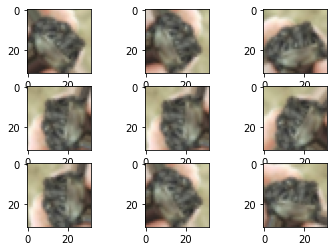

In [21]:
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

sample_images = expand_dims(sample, 0)
# image data augmentation
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(sample_images, batch_size=1)
# generate sample images and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    image = batch[0];
    # plot raw pixel data
    pyplot.imshow(image)

# show the figure
pyplot.show()

In [22]:
def model_summarize(history):
    # plot loss
    pyplot.subplot(121)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train loss')
    pyplot.plot(history.history['val_loss'], color='orange', label='test loss')
    pyplot.show()

In [23]:
def model_train(X_train, y_train, X_test, y_test, batch_size, step_size, no_epochs):
    # image augmentation
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, shear_range=0.2, zoom_range=0.2)
    # prepare iterator
    train_iterator = datagen.flow(X_train, y_train, batch_size=batch_size)
    # fit model
    steps = int(X_train.shape[0] / step_size)
    print(steps)
    checkpoint = K.callbacks.ModelCheckpoint('model1.h5', monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max', save_freq='epoch')
    lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, verbose=1)
    callback_list = [checkpoint, lr_reduce]
    history = model.fit_generator(train_iterator, steps_per_epoch=steps, epochs=no_epochs, validation_data=(X_test, y_test), verbose=1, callbacks=[callback_list])
    # evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=1)
    print('> %.3f' % (acc * 100.0))
    model_summarize(history)

In [24]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [45]:
num_filter = 36
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel))
First_Conv2D = layers.Conv2D(32, (3,3), use_bias=False ,padding='same')(input)
BatchNorm = layers.BatchNormalization()(First_Conv2D)

First_Block = denseblock(BatchNorm,num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [46]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 32, 32, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_105 (BatchN (None, 32, 32, 32)   128         conv2d_104[0][0]                 
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 32, 32, 32)   128         batch_normalization_105[0][0]    
____________________________________________________________________________________________

In [47]:
opt = K.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

781
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


781/781 [==============================] - 116s 138ms/step - loss: 2.1096 - accuracy: 0.2540 - val_loss: 2.3379 - val_accuracy: 0.2216

Epoch 00001: val_accuracy improved from -inf to 0.22160, saving model to model1.h5
Epoch 2/50
781/781 [==============================] - 105s 134ms/step - loss: 1.7103 - accuracy: 0.3733 - val_loss: 1.6295 - val_accuracy: 0.4013

Epoch 00002: val_accuracy improved from 0.22160 to 0.40130, saving model to model1.h5
Epoch 3/50
781/781 [==============================] - 105s 134ms/step - loss: 1.5420 - accuracy: 0.4386 - val_loss: 1.5229 - val_accuracy: 0.4472

Epoch 00003: val_accuracy improved from 0.40130 to 0.44720, saving model to model1.h5
Epoch 4/50
781/781 [==============================] - 105s 134ms/step - loss: 1.3760 - accuracy: 0.5010 - val_loss: 1.3448 - val_accuracy: 0.5277

Epoch 00004: val_accuracy improved from 0.44720 to 0.52770, saving model to model1.h5
Epoch 5/50
781/781 [==============================] - 105s 134ms/step - loss: 1.23

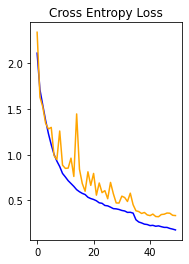

In [48]:
model_train(X_train, y_train, X_test, y_test, 32, 64, 50)

In [49]:
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/model_batch1/',save_format='tf')
model.save('/content/drive/My Drive/CNN_CIFR/model/model_batch1/',save_format='tf')

INFO:tensorflow:Assets written to: /content/model_batch1/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/CNN_CIFR/model/model_batch1/assets


In [52]:
# loading the saved model
del model
model = tf.keras.models.load_model('/content/drive/My Drive/CNN_CIFR/model/model_batch1/')

In [53]:
opt = K.optimizers.Adam(learning_rate=0.00039, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

781
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


781/781 [==============================] - 109s 134ms/step - loss: 0.1798 - accuracy: 0.9348 - val_loss: 0.3309 - val_accuracy: 0.8982

Epoch 00001: val_accuracy improved from -inf to 0.89820, saving model to model1.h5
Epoch 2/20
781/781 [==============================] - 104s 134ms/step - loss: 0.1822 - accuracy: 0.9370 - val_loss: 0.3282 - val_accuracy: 0.8976

Epoch 00002: val_accuracy did not improve from 0.89820
Epoch 3/20
781/781 [==============================] - 104s 134ms/step - loss: 0.1715 - accuracy: 0.9384 - val_loss: 0.3334 - val_accuracy: 0.8969

Epoch 00003: val_accuracy did not improve from 0.89820
Epoch 4/20
781/781 [==============================] - 105s 134ms/step - loss: 0.1724 - accuracy: 0.9404 - val_loss: 0.3316 - val_accuracy: 0.8985

Epoch 00004: val_accuracy improved from 0.89820 to 0.89850, saving model to model1.h5
Epoch 5/20
781/781 [==============================] - 104s 134ms/step - loss: 0.1753 - accuracy: 0.9365 - val_loss: 0.3304 - val_accuracy: 0.899

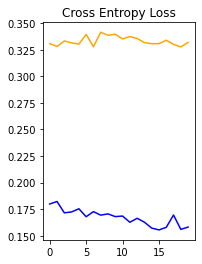

In [54]:
model_train(X_train, y_train, X_test, y_test, 32, 64, 20)

In [55]:
model.save('/content/drive/My Drive/CNN_CIFR/model/model_batch2/',save_format='tf')

model.save('/content/model_batch2/',save_format='tf')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
INFO:tensorflow:Assets written to: /content/drive/My Drive/CNN_CIFR/model/model_batch2/assets
INFO:tensorflow:Assets written to: /content/model_batch2/assets


In [42]:
# loading the saved model
del model
model = tf.keras.models.load_model('/content/model_batch2/')

In [56]:
opt = K.optimizers.Adam(learning_rate=1.5e-05, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

781
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


781/781 [==============================] - 109s 135ms/step - loss: 0.1561 - accuracy: 0.9453 - val_loss: 0.3278 - val_accuracy: 0.9010

Epoch 00001: val_accuracy improved from -inf to 0.90100, saving model to model1.h5
Epoch 2/5
781/781 [==============================] - 105s 134ms/step - loss: 0.1550 - accuracy: 0.9462 - val_loss: 0.3308 - val_accuracy: 0.9000

Epoch 00002: val_accuracy did not improve from 0.90100
Epoch 3/5
781/781 [==============================] - 104s 133ms/step - loss: 0.1580 - accuracy: 0.9440 - val_loss: 0.3299 - val_accuracy: 0.8998

Epoch 00003: val_accuracy did not improve from 0.90100
Epoch 4/5
781/781 [==============================] - 105s 134ms/step - loss: 0.1607 - accuracy: 0.9443 - val_loss: 0.3319 - val_accuracy: 0.9002

Epoch 00004: val_accuracy did not improve from 0.90100
Epoch 5/5
781/781 [==============================] - 104s 134ms/step - loss: 0.1603 - accuracy: 0.9428 - val_loss: 0.3301 - val_accuracy: 0.8999

Epoch 00005: val_accuracy did no

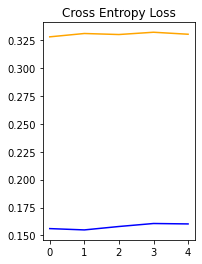

In [57]:
model_train(X_train, y_train, X_test, y_test, 32, 64, 5)

In [58]:
model.save('/content/drive/My Drive/CNN_CIFR/model/model_batch3/',save_format='tf')

model.save('/content/model_batch3/',save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/My Drive/CNN_CIFR/model/model_batch3/assets
INFO:tensorflow:Assets written to: /content/model_batch3/assets
